# Movie Analysis

# Overview

# Business Problem

# Data Understanding

# Data Preparation : Cleaning and Filtering

## Import

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.stats.power as smp
import sqlite3
import warnings
warnings.simplefilter("ignore")

import requests
from bs4 import BeautifulSoup

## Master data set by Andrei and Namsoo

In [ ]:
# Assign csv files and im.db
movie_tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
theatre_weekend = pd.read_csv('zippedData/weekend_theaters_numbers.csv')
conn = sqlite3.connect('zippedData/im.db')

### Clean database and tables

In [ ]:
# Assign database to dataframe
sql_query = pd.read_sql_query ('''
                               SELECT
                               mb.original_title,
                               mb.start_year,
                               mb.runtime_minutes,
                               mb.genres,
                               mr.averagerating,
                               mr.numvotes,
                               p.primary_name,
                               p.primary_profession
                               FROM movie_akas
                               JOIN movie_ratings mr
                               USING(movie_id)
                               JOIN movie_basics mb
                               USING(movie_id)
                               JOIN writers
                               USING(movie_id)
                               JOIN persons p
                               USING(person_id)
                               WHERE start_year >= 2010
                               AND region = 'US'
                               GROUP BY primary_title
                               ''', conn)

df = pd.DataFrame(sql_query, columns = [
    'original_title', 'start_year', 'runtime_minutes', 
    'genres', 'averagerating', 'numvotes',
    'primary_name', 'primary_profession']
)

In [ ]:
# Clean original_title by lowering case
df.original_title = df.original_title.str.lower()
df.genres = df.genres.str.lower()

# Fillin missing values of runtime_minutes with mean
df.runtime_minutes = df.runtime_minutes.fillna(df.runtime_minutes.mean())

# Rename columns
df = df.rename(columns={'original_title': 'movie',
                        'start_year':'release_year'})

# Drop missing values
df = df.dropna(subset=['genres', 'primary_profession'])

In [ ]:
# Clean the movie_budget table
movie_budget.release_date = pd.to_datetime(movie_budget.release_date) # Changing datatype for next filtering
movie_budget = movie_budget[movie_budget.release_date >= '2010-01-01'] # Filtering target duration
movie_budget = movie_budget.drop(columns=['id',
                                          'worldwide_gross',
                                          'release_date'
                                          ]
                                          ) # Dropping unrelevant data
movie_budget.movie = movie_budget.movie.str.lower() # Lowring title case



In [ ]:
# Clean the theaters_numbers table
theatre_weekend = theatre_weekend.drop(columns=['year', 'rank']) # Dropping unrelevant data
theatre_weekend = theatre_weekend.dropna(subset=['domestic_box_office',
                                                 'opening_weekend_box_office',
                                                 'movie', 
                                                ]
                                                ) # Dropping missing values which make noise in analysis
theatre_weekend.movie = theatre_weekend.movie.str.lower() # Lowring title case

# Fill-in missing values with a correct category
theatre_weekend.distributor = theatre_weekend.distributor.fillna("No Distributor") 



In [ ]:
# Clean the movie_tmdb table
movie_tmdb.release_date = pd.to_datetime(movie_tmdb.release_date) # Changing datatype for next filtering
movie_tmdb = movie_tmdb[movie_tmdb.release_date >= '2010-01-01'] # Filtering target duration

# Dropping unrelevant data
movie_tmdb = movie_tmdb.drop(columns=['Unnamed: 0', 
                                      'genre_ids', 
                                      'id', 
                                      'original_language',
                                      'original_title'
                                      ]
                                      )

movie_tmdb.title = movie_tmdb.title.str.lower() # Lowring title case
movie_tmdb =movie_tmdb.rename(columns={'title':'movie'}) # Rename a column for merging



### Merging Data Sets and Making calculations and columns in order

In [ ]:
# Merging Data Sets using the movie column
merge_1 = pd.merge(movie_tmdb, df, on="movie")
merge_2 = pd.merge(merge_1,theatre_weekend, on="movie")
data = pd.merge(merge_2,movie_budget, on="movie")

In [ ]:
conn4 = sqlite3.connect('zippedData/master_andrei_sql.db') # Create a sql db and Connect
data.to_sql('master_andrei_sql', conn4, if_exists='replace', index=False) # Transform df to db

# Making calcumations and columns in order
master_crafted = pd.read_sql(
    """
    WITH modified AS 
    (
    SELECT
        DISTINCT movie AS movie_name,
        CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',', '') AS FLOAT) AS domestic_gross_numeric,
        CAST(REPLACE(REPLACE(production_budget, '$', ''), ',', '') AS FLOAT) AS production_budget_numeric,
        CAST(REPLACE(REPLACE(opening_weekend_box_office, '$', ''), ',', '') AS FLOAT) AS opening_weekend_boxoffice,
        *
    FROM master_andrei_sql
    ORDER BY movie
    )

    SELECT
        movie_name,
        genres,
        ROUND(domestic_gross_numeric/ production_budget_numeric*100, 2) AS percentage_ROI_gross_budget,
        domestic_gross_numeric AS gross,
        production_budget_numeric AS budget,
        opening_weekend_boxoffice,
        (vote_average + averagerating)/2 AS average_rating,
        ROUND((vote_count + numvotes)/2, 0) AS number_vote,
        primary_name,
        primary_profession,
        release_date,
        release_year,
        runtime_minutes,
        distributor,
        max_theatre_count

    FROM modified 
    ORDER BY release_date
    ;
    """
, conn4
)

### Sanity Check of Master Data set and Create a csv master file

In [ ]:
# de-duplicate on movie_name and release_year
master_dedup = master_crafted.drop_duplicates(subset=['movie_name', 'release_year']) 

master_dedup.to_csv('zippedData/master_dedup_v2.csv', index=False) # Create a csv file for further analysis

# Data Analysis

## Analysis by Kari

In [37]:
master_final_df = pd.read_csv('zippedData/master_dedup_v2.csv')

### Two Sample T-Test: One-tailed

**Null Hypothesis:** The mean ROI of horror movies is less than or equal to that of non-horror movies.

**Alternative Hypothesis:** The mean ROI of horror movies is greater than that of non-horror movies.


#### Create Sample Groups

In [38]:
# Split data into two groups (samples)
horror_movies = master_final_df[master_final_df['genres'].str.contains('horror', case=False, regex=True)]
non_horror_movies = master_final_df[~master_final_df['genres'].str.contains('horror', case=False, regex=True)]

# Sanity check
horror_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 11 to 1275
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_name                   150 non-null    object 
 1   genres                       150 non-null    object 
 2   percentage_ROI_gross_budget  150 non-null    float64
 3   gross                        150 non-null    float64
 4   budget                       150 non-null    float64
 5   opening_weekend_boxoffice    150 non-null    float64
 6   average_rating               150 non-null    float64
 7   number_vote                  150 non-null    float64
 8   primary_name                 150 non-null    object 
 9   primary_profession           150 non-null    object 
 10  release_date                 150 non-null    object 
 11  release_year                 150 non-null    int64  
 12  runtime_minutes              150 non-null    float64
 13  distributor            

In [39]:
# Sanity check
non_horror_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1140 entries, 0 to 1289
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_name                   1140 non-null   object 
 1   genres                       1140 non-null   object 
 2   percentage_ROI_gross_budget  1140 non-null   float64
 3   gross                        1140 non-null   float64
 4   budget                       1140 non-null   float64
 5   opening_weekend_boxoffice    1140 non-null   float64
 6   average_rating               1140 non-null   float64
 7   number_vote                  1140 non-null   float64
 8   primary_name                 1140 non-null   object 
 9   primary_profession           1140 non-null   object 
 10  release_date                 1140 non-null   object 
 11  release_year                 1140 non-null   int64  
 12  runtime_minutes              1140 non-null   float64
 13  distributor            

#### Interpretation of Two-Sample T-Test (One-Tailed)

The result of this analysis indicates that there is a 95% chance that the mean ROI of horror movies is significantly greater than the mean ROI of non-horror movies. 


In [40]:
# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the mean 'ROI' of horror and non-horror movies
t_statistic, p_value = stats.ttest_ind(horror_movies['percentage_ROI_gross_budget'], non_horror_movies['percentage_ROI_gross_budget'], equal_var=False)


# Determine whether to reject the null
if p_value < alpha and t_statistic < 0:  
    result = 'Reject the null hypothesis'
    
elif p_value < alpha and t_statistic > 0:  
    result = 'Reject the null hypothesis'
else:
    result = 'Fail to reject the null hypothesis'


# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')
print(f'Result: {result}')


T-statistic: 2.890674145719811
P-value: 0.004417071508529201
Result: Reject the null hypothesis


#### Power Analysis of Two-Sample T-Test

In [41]:
# Determine effect size using Cohen's d for a two-sample test

horror_mean =  horror_movies['percentage_ROI_gross_budget'].mean()
non_horror_mean =  non_horror_movies['percentage_ROI_gross_budget'].mean()
horror_std =   horror_movies['percentage_ROI_gross_budget'].std()
non_horror_std =   horror_movies['percentage_ROI_gross_budget'].std()

horror_sample = 150
non_horror_sample = 1140

# Calculate pooled standard deviation
pooled_std = np.sqrt(((horror_sample - 1) * horror_std**2 + (non_horror_sample - 1) * non_horror_std**2) / (horror_sample + non_horror_sample - 2))

# Calculate Cohen's d
effect_sizes = (horror_mean - non_horror_mean) / pooled_std

effect_sizes


0.2362376885444173

In [42]:
# Set the parameters for the power analysis
effect_size = .236238  # Set effect_size according to Cohen's d calculation
alpha = 0.05  # Set significance level
alternative = 'two-sided'

# Perform the power analysis with given sample sizes
analysis = smp.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, alpha=alpha, nobs1=horror_sample, ratio=non_horror_sample/horror_sample, alternative=alternative)

print(f'Statistical Power: {result}')


Statistical Power: 0.7757482834707635


##### Interpretation of Power Analysis

A statistical power of 0.7757 means that there is a 77.57% chance that if there is a real difference or effect between the horror ROI and non_horror ROI, our test will detect it. This is a reasonably good statistical power and we are slightly reducing the risk of a Type II error (false-negative).

### Multiple Linear Regression Model

#### Independent Variables

**Null Hypothesis:** The variables have no effect on ROI, and their coefficients are equal to zero.

**Alternative Hypothesis:** The variables have an effect on ROI, and their coefficients are not equal to zero.


#### Dependent Variable

**Null Hypothesis:** The intercept represents a baseline ROI when all independent variables are zero.

**Alternative Hypothesis:** The intercept does not represent a meaningful baseline ROI when all independent variables are zero.


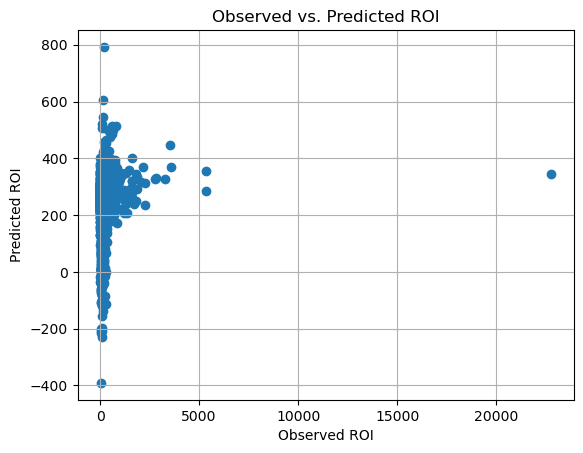

                                 OLS Regression Results                                
Dep. Variable:     percentage_ROI_gross_budget   R-squared:                       0.020
Model:                                     OLS   Adj. R-squared:                  0.018
Method:                          Least Squares   F-statistic:                     8.800
Date:                         Fri, 27 Oct 2023   Prob (F-statistic):           8.90e-06
Time:                                 14:48:39   Log-Likelihood:                -10336.
No. Observations:                         1290   AIC:                         2.068e+04
Df Residuals:                             1286   BIC:                         2.070e+04
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [43]:
# Add constant intercept to variables
X = sm.add_constant(master_final_df[['budget', 'average_rating', 'number_vote']])

# Dependent variable
y = master_final_df['percentage_ROI_gross_budget']

# Apply fit test to model
model = sm.OLS(y, X).fit()

# Predicted values from model
predicted_values = model.predict(X)

# Create a scatter plot of observed vs. predicted ROI values
plt.scatter(y, predicted_values)
plt.xlabel('Observed ROI')
plt.ylabel('Predicted ROI')
plt.title('Observed vs. Predicted ROI')
plt.grid(True)
plt.show()


# Regression summary
print(model.summary())


#### Interpretation

The low R-squared value suggests that this model may not be a good fit for explaining ROI. Additional factors or variables may be needed to improve its performance.

However, the results indicate that 'budget' and 'number_vote' are statistically significant predictors of ROI because they have very low p-values, while 'average_rating' may not be relevant in explaining variations in ROI.

### Linear Regression Model: budget & gross (revenue)

#### Independent Variable

**Null Hypothesis:** The variable has no effect on revenue, and the coefficient is equal to zero.

**Alternative Hypothesis:** The variable has an effect on revenue, and the coefficient is not equal to zero.


#### Dependent Variable

**Null Hypothesis:** The intercept represents a baseline revenue when the independent variable is zero.

**Alternative Hypothesis:** The intercept does not represent a meaningful baseline revenue when the independent variable is zero.

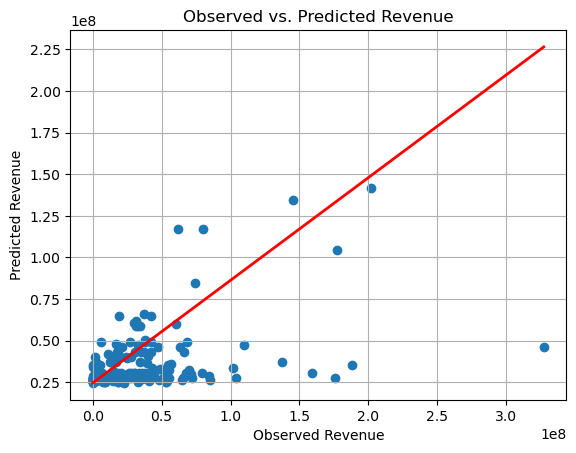

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     32.29
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           6.83e-08
Time:                        14:48:51   Log-Likelihood:                -2843.0
No. Observations:                 150   AIC:                             5690.
Df Residuals:                     148   BIC:                             5696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.456e+07   4.07e+06      6.039      0.0

In [44]:
# Add constant intercept to variables
X = sm.add_constant(horror_movies[['budget']])

# Dependent variable
y = horror_movies['gross']

# Apply fit test to model
model = sm.OLS(y, X).fit()

# Predicted values from model
predicted_values = model.predict(X)

# Create a scatter plot of observed vs. predicted ROI values
plt.scatter(y, predicted_values)
plt.xlabel('Observed Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Observed vs. Predicted Revenue')
plt.grid(True)

# Calculate the minimum and maximum 'gross' values
min_gross = min(y)
max_gross = max(y)

# Create x values for the trendline (from min to max 'gross')
x_trendline = np.linspace(min_gross, max_gross, 100)

# Calculate corresponding predicted values for the trendline
y_trendline = model.predict(sm.add_constant(x_trendline))

# Add a regression line
plt.plot(x_trendline, y_trendline, color='red', linewidth=2, label='Trendline')


plt.show()


# Regression summary
print(model.summary())


#### Interpretation

The low R-squared value suggests that budget explains only a small portion (17.9%) of the variance in revenue for horror movies.

However, the results indicate that horror movie budgets are a statistically significant predictor of horror movie revenue because of its low p-value for the F-statistic and coefficient. 

Therefore, although budget is statistically significant in this model, there are other variables that can influence horror movie revenue.

### Multiple Linear Regression Model: budget, genres, primary_name

In [45]:
from sklearn.preprocessing import LabelEncoder

# Create separate LabelEncoder instances for 'Genre' and 'Director'
label_encoder_genres = LabelEncoder()
label_encoder_primary_name = LabelEncoder()

# Apply label encoding to 'Genre' column
master_final_df['genres_encoded'] = label_encoder_genres.fit_transform(master_final_df['genres'])

# Apply label encoding to 'Director' column
master_final_df['primary_name_encoded'] = label_encoder_primary_name.fit_transform(master_final_df['primary_name'])

# Resulting DataFrame with label encoding for both columns
master_final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_name                   1290 non-null   object 
 1   genres                       1290 non-null   object 
 2   percentage_ROI_gross_budget  1290 non-null   float64
 3   gross                        1290 non-null   float64
 4   budget                       1290 non-null   float64
 5   opening_weekend_boxoffice    1290 non-null   float64
 6   average_rating               1290 non-null   float64
 7   number_vote                  1290 non-null   float64
 8   primary_name                 1290 non-null   object 
 9   primary_profession           1290 non-null   object 
 10  release_date                 1290 non-null   object 
 11  release_year                 1290 non-null   int64  
 12  runtime_minutes              1290 non-null   float64
 13  distributor       

Mean Squared Error: 4065359596403251.50
R-squared: 0.42


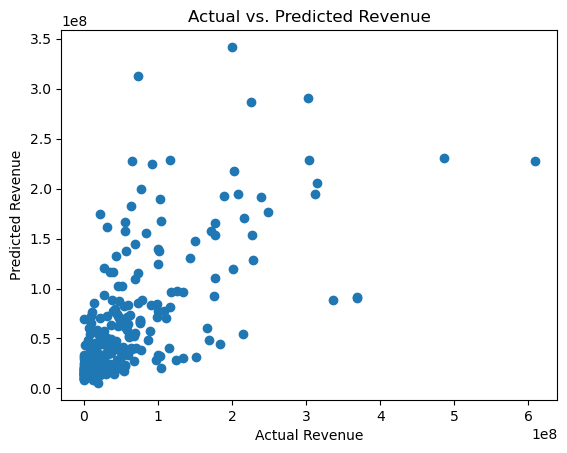

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the dataset (replace 'df' with your dataset)
# Ensure that 'budget' and 'revenue' are numerical columns.
# Encode categorical variables like genres and directors.

# Split the data into training and testing sets
x = master_final_df[['budget', 'genres_encoded', 'primary_name_encoded']]  # Features
y = master_final_df['gross']  # Target variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train a linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
mae = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mae:.2f}")
print(f"R-squared: {r_squared:.2f}")

# Visualize predictions vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Revenue")
plt.show()

## Analysis by Namsoo

### Monthly Trends of Number of Movies, Budget, Gross, and Opening Weekend Boxoffice

#### Data Preparation for Monthly Trends

In [47]:
master_dedup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1290 entries, 0 to 1471
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_name                   1290 non-null   object 
 1   genres                       1290 non-null   object 
 2   percentage_ROI_gross_budget  1290 non-null   float64
 3   gross                        1290 non-null   float64
 4   budget                       1290 non-null   float64
 5   opening_weekend_boxoffice    1290 non-null   float64
 6   average_rating               1290 non-null   float64
 7   number_vote                  1290 non-null   float64
 8   primary_name                 1290 non-null   object 
 9   primary_profession           1290 non-null   object 
 10  release_date                 1290 non-null   object 
 11  release_year                 1290 non-null   int64  
 12  runtime_minutes              1290 non-null   float64
 13  distributor            

In [48]:
# Transform master_dedup to a sql database
conn5 = sqlite3.connect('zippedData/master_1.db')
master_dedup.to_sql('master_1', conn5, if_exists='replace', index=False)

1290

In [49]:
# Extract months from 'release_date' column by using STRFTIME
# SELECT AVG()
line_graph = pd.read_sql(
    """
    SELECT
        STRFTIME('%m', release_date) AS months,
        AVG(percentage_ROI_gross_budget) AS avg_ROI,
        AVG(gross) AS avg_gross,
        AVG(opening_weekend_boxoffice) AS avg_opening_gross,
        AVG(budget) AS avg_budget,
        COUNT(*) AS number_movie
    FROM master_1 
    GROUP BY months
    ORDER BY months
    ;
    """
, conn5
)

In [50]:
line_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   months             12 non-null     object 
 1   avg_ROI            12 non-null     float64
 2   avg_gross          12 non-null     float64
 3   avg_opening_gross  12 non-null     float64
 4   avg_budget         12 non-null     float64
 5   number_movie       12 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 704.0+ bytes


#### Number of Movies by Month

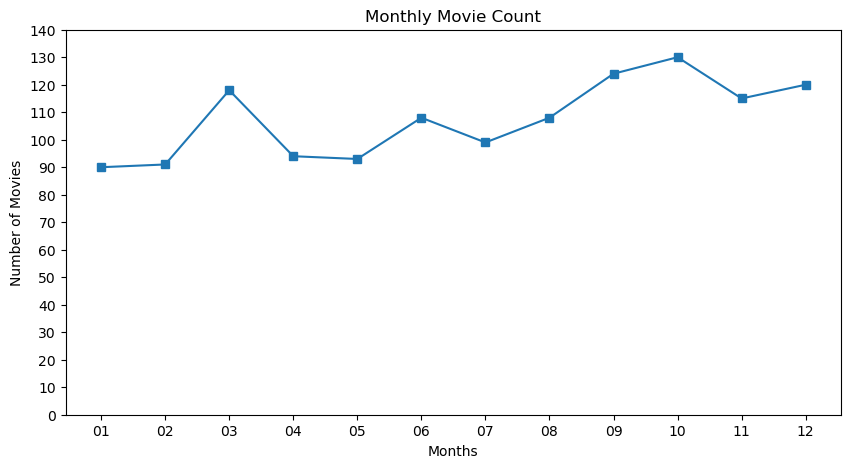

In [51]:
# Line graph of number_movie by months
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(line_graph['months'], line_graph['number_movie'], marker='s', linestyle='-')

ax.set_yticks(range(0, 141, 10))  # This sets ticks from 0 to 130 in steps of 10
ax.set_xlabel('Months')
ax.set_ylabel('Number of Movies')
ax.set_title('Monthly Movie Count')

plt.show();




#### Average of Budget, Gross, and Opening_Gross by Month

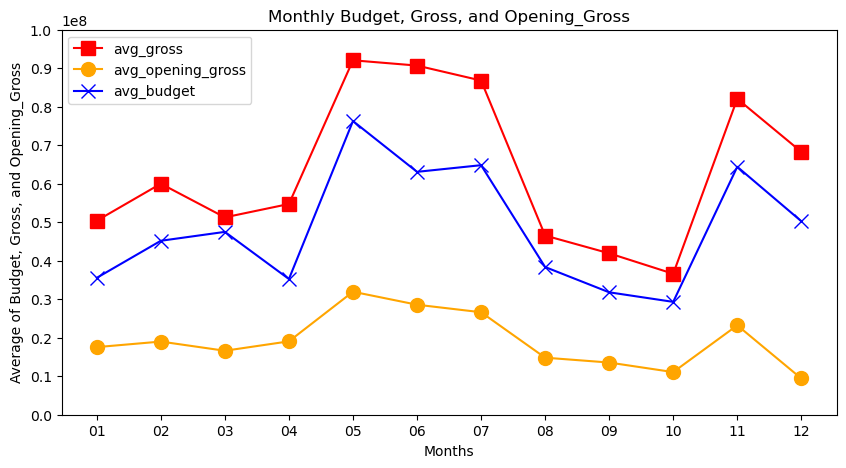

In [54]:
# Line graph of gross, opening_gross, and budget
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(line_graph['months'], line_graph['avg_gross'], label = 'avg_gross', marker='s', markersize=10, linestyle='-', color='red')

ax.plot(line_graph['months'], line_graph['avg_opening_gross'], label = 'avg_opening_gross', marker='o', markersize=10, linestyle='-', color='orange')

ax.plot(line_graph['months'], line_graph['avg_budget'], label = 'avg_budget', marker='x', markersize=10, linestyle='-', color='blue')

ax.set_yticks(range(0, 110000000, 10000000))  # This sets ticks from 0 to 130 in steps of 10
ax.set_xlabel('Months')
ax.set_ylabel('Average of Budget, Gross, and Opening_Gross')
ax.set_title('Monthly Budget, Gross, and Opening_Gross')

plt.legend(loc='upper left')

plt.show();





### What Are the Most Profitable Genres?

#### Within our dataset, we have 205 different movie genres. To find out which genres are the most profitable, we will focus on genres that have more than 6 movies. In terms of the number of movies, 6 falls within the top 25% of movies.

#### Calculating the number of movies in the 75th percentile

In [56]:
number_movies_genres = pd.read_sql(
    """
    SELECT
        genres,
        COUNT(*) AS number_movie
    FROM master_1 
    GROUP BY genres
    ORDER BY number_movie DESC
    ;
    """
, conn5
)

In [57]:
number_movies_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        205 non-null    object
 1   number_movie  205 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [58]:
number_movies_genres['number_movie'].describe()

count    205.000000
mean       6.292683
std       10.144650
min        1.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       63.000000
Name: number_movie, dtype: float64

#### Horror releated genres are in top 4 ROI

In [70]:
pd.read_sql(
    """
   WITH gen_roi_num AS 
   (
    SELECT
        genres,
        AVG(percentage_ROI_gross_budget) AS AVG_ROI,
        COUNT(*) AS Num_Movie
    FROM master_1 
    GROUP BY genres
    ORDER BY AVG_ROI DESC
    )

    SELECT 
        DENSE_RANK() OVER(ORDER BY AVG_ROI DESC) AS Rank_N,
        genres,
        AVG_ROI,
        Num_Movie
        

    FROM gen_roi_num
    WHERE Num_Movie > 6
    ORDER BY AVG_ROI DESC
    LIMIT 5
    ;
    """
, conn5
)

,Rank_N,genres,AVG_ROI,Num_Movie
0,1,"horror,mystery,thriller",1902.296538,26
1,2,horror,735.743077,13
2,3,"horror,thriller",547.683043,23
3,4,"drama,horror,mystery",316.337000,10
4,5,"drama,fantasy,romance",304.714286,7


# Conclusions

# Next steps